<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Оценка-влияния-поля-Tenure" data-toc-modified-id="Оценка-влияния-поля-Tenure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Оценка влияния поля Tenure</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Исследование-баланса-классов" data-toc-modified-id="Исследование-баланса-классов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Исследование баланса классов</a></span></li><li><span><a href="#Модель-без-учета-дизбаланса" data-toc-modified-id="Модель-без-учета-дизбаланса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель без учета дизбаланса</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import platform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score, r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

Импорт/установка прогресс-бара

In [2]:
try:
    from tqdm import tqdm
except:
    !from pandas_profiling import tqdm

Импорт/установка библиотеки отчетов по переменным

In [3]:
try:
    from pandas_profiling import ProfileReport
except:
    !pip install pandas_profiling
    !pip install ipywidgets
    from pandas_profiling import ProfileReport

In [4]:
host = platform.node()
filename = "Churn.csv"

# На машинах исполнителя проекта файл с данными доступен через символический путь, 
# ссылающийса на папку на яндекс.диске, где расположен загружаемый файл. 
# В случае если хостом где выполняется анализ является какая-либо другая машина, 
# используем путь по умолчанию.
try:    
    if host in ['22varivoda','Gover-pc','MSI']:
        filepath    = 'C:/_YDsymlink/Python/datascience/Projects/17 - GIT/'
    else:
        filepath    = '/datasets/'
except:
    print("Не удалось подгрузить данные")
    
pd.reset_option('^display.',silent=True)
pd.set_option('display.float_format', str)


Фиксация random_state

In [5]:
np.random.seed(0)
rand_const = 333

In [6]:
df = pd.read_csv(filepath+filename)

Описание данных (признаки):
- <code>RowNumber</code> — индекс строки в данных
- <code>CustomerId</code> — уникальный идентификатор клиента
- <code>Surname</code> — фамилия
- <code>CreditScore</code> — кредитный рейтинг
- <code>Geography</code> — страна проживания
- <code>Gender</code> — пол
- <code>Age</code> — возраст
- <code>Tenure</code> — сколько лет человек является клиентом банка
- <code>Balance</code> — баланс на счёте
- <code>NumOfProducts</code> — количество продуктов банка, используемых клиентом
- <code>HasCrCard</code> — наличие кредитной карты
- <code>IsActiveMember</code> — активность клиента
- <code>EstimatedSalary</code> — предполагаемая зарплата

Целевой признак
- <code>Exited</code> — факт ухода клиента

Из общего числа столбцов выделим столбцы признаков (оставив за бортом столбцы, не несущие полезной информации, например идентификаторы). Сдалаем список с числовыми признаками, категориальными признаками и общий.

In [7]:
numeric_vars = ['CreditScore',
                'Age',
                'Tenure',
                'Balance',
                'NumOfProducts',
                'EstimatedSalary']

In [8]:
categorial_vars = ['Geography',
                   'Gender',
                   'HasCrCard',
                   'IsActiveMember']

In [9]:
features_vars = numeric_vars + categorial_vars

Изучаем данные

In [10]:
df.sample(5)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
9394       9395    15615753  Upchurch          597   Germany  Female   35   
898         899    15654700   Fallaci          523    France  Female   40   
2398       2399    15633877  Morrison          706     Spain  Female   42   
5906       5907    15745623   Worsnop          788    France    Male   32   
2343       2344    15765902    Gibson          706   Germany    Male   38   

      Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9394     8.0 131101.04              1          1               1   
898      2.0 102967.41              1          1               0   
2398     8.0  95386.82              1          1               1   
5906     4.0 112079.58              1          0               0   
2343     5.0 163034.82              2          1               1   

      EstimatedSalary  Exited  
9394        192852.67       0  
898          128702.1       1  
2398         75732.25       0  
5906         89368.59       0  
2343        135662.17       0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Все столбцы кроме <code>Tenure</code>(сколько лет человек является клиентом банка) не содержат прямых пропусков, посмотрим что за запси содержат пропуски в этом столбце

In [12]:
df.loc[df.Tenure.isna()].sample(10, random_state = rand_const)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
4989       4990    15602851    Ozioma          629    France    Male   40   
2441       2442    15691446  Tokaryev          735     Spain    Male   29   
765         766    15812351   Beluchi          710     Spain  Female   27   
9109       9110    15703682  Kalinina          681     Spain    Male   33   
9889       9890    15711489   Azikiwe          760     Spain  Female   32   
4445       4446    15736413      Hall          739    France    Male   29   
7782       7783    15595991    Hsiung          585    France    Male   54   
2512       2513    15769522  O'Connor          734    France    Male   51   
6013       6014    15609899    Obiora          548     Spain    Male   37   
7100       7101    15668830       Wan          650     Spain    Male   24   

      Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
4989     NaN       0.0              1          1               0   
2441     NaN       0.0              2          1               1   
765      NaN 135277.96              1          1               0   
9109     NaN       0.0              1          0               0   
9889     NaN       0.0              1          1               1   
4445     NaN       0.0              2          1               1   
7782     NaN  87105.32              1          1               1   
2512     NaN 118537.47              1          1               1   
6013     NaN       0.0              1          1               0   
7100     NaN 108881.73              1          1               0   

      EstimatedSalary  Exited  
4989           106.67       0  
2441         95025.27       0  
765         142200.15       0  
9109        158336.36       0  
9889        114565.35       0  
4445        164484.78       0  
7782         55346.14       0  
2512        116912.45       0  
6013        121763.68       0  
7100        104492.83       0

Для сравнения посмотрим на записи у которыхполе Tenure заполнено

In [13]:
df.loc[df.Tenure.isna() == False].sample(10, random_state = rand_const)

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
1481       1482    15583748   McGuigan          592     Spain    Male   38   
5017       5018    15777599   Esposito          746   Germany    Male   34   
4491       4492    15726832   Donnelly          850   Germany    Male   61   
8746       8747    15577905    Hammond          660    France    Male   34   
5182       5183    15613102  Ogochukwu          670    France  Female   31   
9280       9281    15614847   Townsend          674    France  Female   45   
7409       7410    15688059       Chin          807   Germany  Female   42   
1231       1232    15749482       Zack          772     Spain    Male   30   
3009       3010    15660200        Mai          551    France    Male   31   
5036       5037    15805429     Murray          699   Germany    Male   59   

      Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
1481     8.0       0.0              2          1               0   
5017     6.0  141806.0              2          1               1   
4491     3.0 141784.02              1          1               1   
8746     8.0 106486.66              2          0               1   
5182     2.0  57530.06              1          1               1   
9280     6.0  72494.69              1          0               1   
7409     9.0 105356.09              2          1               1   
1231     4.0  78653.05              1          1               0   
3009     1.0       0.0              2          1               1   
5036     3.0 106819.65              1          0               1   

      EstimatedSalary  Exited  
1481         180426.2       0  
5017        183494.87       0  
4491         92053.75       0  
8746        182262.66       0  
5182        181893.31       1  
9280        140041.78       0  
7409        130489.37       0  
1231          1790.48       0  
3009        185105.44       0  
5036        163570.25       0

Никаких концептуальных отличий в записях с пустым полем Tenure и заполненным не видно. Попробуем упорядочить таблицу по CustomerId. Так как обычно более новые клиенты в базах данных больший идентификатор чем старые (нумерация идет от единицы к бесконечности)

In [14]:
df.sort_values(by='CustomerId').tail(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
9243       9244    15815534    Guidry          505     Spain    Male   37   
5597       5598    15815552  Ferguson          670    France  Female   42   
1933       1934    15815560     Bogle          666   Germany    Male   74   
6640       6641    15815615      Kung          681    France    Male   36   
2078       2079    15815626    Oluchi          640    France    Male   63   
3411       3412    15815628    Moysey          711    France  Female   37   
8271       8272    15815645    Akhtar          481    France    Male   37   
8088       8089    15815656   Hopkins          541   Germany  Female   39   
1762       1763    15815660     Mazzi          758    France  Female   34   
5502       5503    15815690  Akabueze          614     Spain  Female   40   

      Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9243     0.0 134006.39              1          1               1   
5597     6.0 112333.63              1          1               1   
1933     7.0  105102.5              1          1               1   
6640     NaN 141952.07              1          1               1   
2078     2.0  68432.45              2          1               1   
3411     8.0 113899.92              1          0               0   
8271     8.0 152303.66              2          1               1   
8088     9.0 100116.67              1          1               1   
1762     1.0 154139.45              1          1               1   
5502     NaN  113348.5              1          1               1   

      EstimatedSalary  Exited  
9243         93736.69       0  
5597         65706.86       0  
1933         46172.47       0  
6640        185144.08       0  
2078        112503.24       1  
3411          80215.2       0  
8271         175082.2       0  
8088         199808.1       1  
1762         60728.89       0  
5502         77789.01       0

К сожалению идентификатор нам не помог: у записей с бОльшими значениями идентификатора встречаются как старые так и новые клиенты.<BR>
Других возможностей установить истинное значение поля Tenure для пропусков не наблюдается. 
Посему поступим следующим образом:<BR>
1) добавим столбец tenure_nan_filled и внесем туда значение 1 для тех записей где есть пропуск<BR>
2) в столбец Tenure для них запишем медианное значение<BR>
3) позже сделаем модель логистической регрессии и обучим её по тем записям где этот столбец <i><u>был</u></i> заполнен изначально<BR>
4) посмотрим коэффициенты столбцов для логистической регрессии. Если у поля Tenure значение будет маленьким то особого внимания на него обращать не будем, так как его значение в работе алгоритма мало. Если же коэффициент будет большим то будем думать что делать дальше. Возможно что записи с пустующим полем придется исключить и обучать модель без них.

Добавляем столбец и обнуляем Tenure там где есть пустые ячейки

In [15]:
df['tenure_nan_filled']=0
df.loc[df['Tenure'].isna(),'tenure_nan_filled']=1
df.loc[df['Tenure'].isna(),'Tenure']=df['Tenure'].median()

Проверка

In [16]:
print(f"Число записей с пустым столбцом Tenure: {len(df.loc[df['Tenure'].isna()])}")
print(f"Число записей с столбцом tenure_nan_filled равным единице: {len(df.loc[df['tenure_nan_filled'] == 1])}")

Число записей с пустым столбцом Tenure: 0
Число записей с столбцом tenure_nan_filled равным единице: 909


Для проверки состояния подгруженной базы, проверки значений в столбцах на адекватность, воспользуемся функцией ProfileReport() из библиотеки pandas_profiling

In [17]:
ProfileReport(df,title = 'Отчет по подгруженной базе данных')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Странновато выглядят минимальные значения в в толбце EstimatedSalary, 11.58 и соседние значения не выглядят правдоподобными, но проверить/заменить их не на что, возможно это официально оформленный доход, а реальный поступает по-черному.

В остальном все данные выглядят вполне нормальными.

### Оценка влияния поля Tenure

Ранее было упомянуто что для оценки важности поля Tenure (сколько человек является клиентом банка) мы планировали использовать модель логистической регрессии с оценкой коэффициента. Прежде всего попробуем сделать эту оценку. Здесь ещё не идёт нормальная работа с моделью. Лишь грубая-грубая оценка важности поля Tenure и всё. Основная работа будет в следующем разделе.

In [18]:
t_df = df.loc[df['tenure_nan_filled'] == False]

In [19]:
t_features=t_df.drop('Exited',axis=1).drop('tenure_nan_filled',axis=1).loc[:,features_vars]
t_target  =t_df['Exited']

In [20]:
t_features = pd.get_dummies(t_features,drop_first=True)


In [21]:
t_features_train, t_features_valid, t_target_train, t_target_valid = train_test_split(
    t_features, t_target, test_size = 0.25, random_state = rand_const)

Масштабируем

In [22]:
print(pd.options.mode.chained_assignment)

warn


In [23]:
scaler = StandardScaler()
scaler.fit(t_features_train[numeric_vars])
pd.options.mode.chained_assignment = None
t_features_train[numeric_vars] = scaler.transform(t_features_train[numeric_vars])
t_features_valid[numeric_vars] = scaler.transform(t_features_valid[numeric_vars])
pd.options.mode.chained_assignment = 'warn'

In [24]:
t_model = LogisticRegression(random_state=12345, max_iter=100, solver='liblinear')

In [25]:
t_model.fit(t_features_train, t_target_train)

LogisticRegression(random_state=12345, solver='liblinear')

In [26]:
t_predicted_valid = t_model.predict(t_features_valid)

In [27]:
accuracy_score(t_target_valid, t_predicted_valid)

0.8095028596568412

Получили цифру.<u>Для задачи оценки значимости поля Tenure</u> ее достаточно.

In [28]:
for i in range(0,len(t_features.columns)):
    if t_features.columns[i] == 'Tenure':
        tenure_weight= t_model.coef_[0][i]

In [29]:
tenure_weight*=100000

Посмотрим значение расчитанного логистической регрессией веса для параметра Tenure

In [30]:
tenure_weight

-4080.0063481945162

In [31]:
coef_ser = pd.Series(t_model.coef_[0])*100000


Также посмотрим на среднеий вес всех коэффициентов и на крайние значения, чтобы оценить значимость Tenure

In [32]:
print(f"max: {coef_ser.max()}")
print(f"mean: {coef_ser.mean()}")
print(f"min: {coef_ser.min()}")

max: 86423.78867748578
mean: 1408.7973299292194
min: -106846.27411443682


<AxesSubplot:>

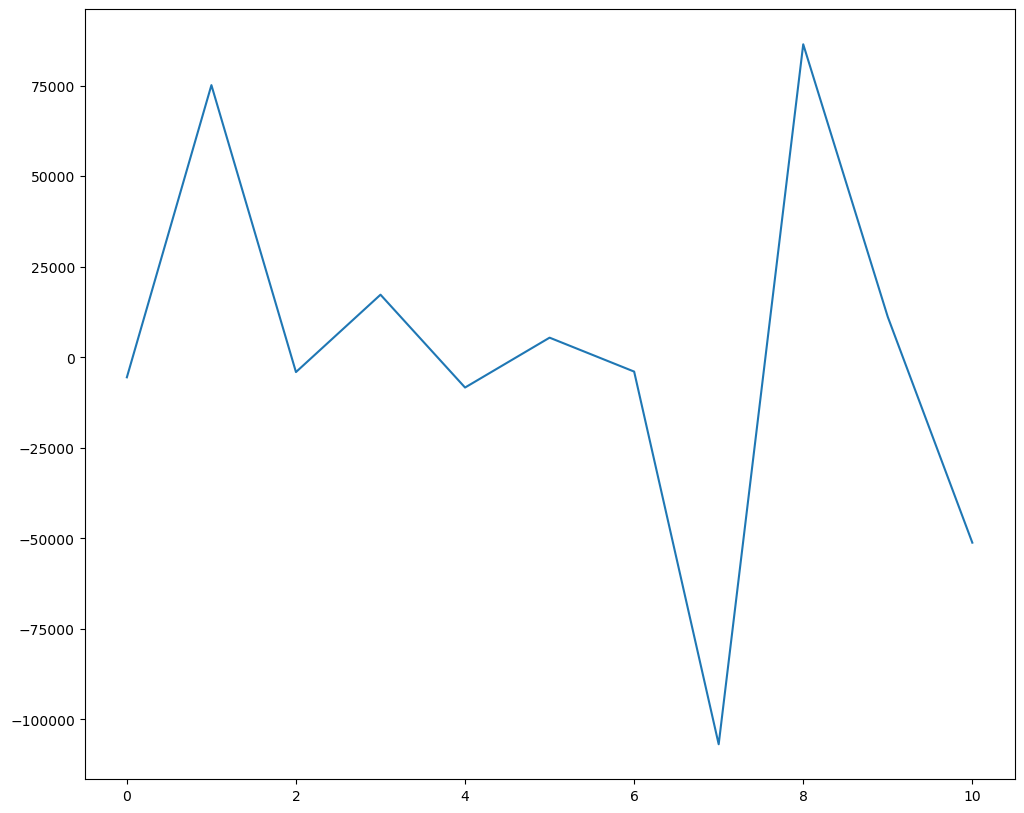

In [33]:
coef_ser.plot(kind='line',figsize=(12,10))

<B>ВЫВОД</B>

Рассчитанное нашей грубой моделью значение веса для поля Tenure показывает что его вес близок среднему (и нулевому) значению, что говорит о том что этот столбец почти ни на что не влияет. Посему спокойно оставляем для пустых ячеек медианное значение и действуем дальше.

## Исследование задачи

### Исследование баланса классов

Разделим данные на тестовую, валидационную и обучающую выборки

In [34]:
df_work, df_test = train_test_split(df, test_size = 0.1, random_state = rand_const)

Выделяем признаки

In [35]:
features = df_work.drop(['Exited','tenure_nan_filled'],axis = 1).loc[:,features_vars]
target = df_work['Exited']

Раскладываем некоторые признаки через One-hot Encoding, защищаемся от dummy-ловушки

In [36]:
features = pd.get_dummies(features,drop_first=True)

Разделяем на три выборки: обучающую, валидационную и тестовую

In [37]:
# Обучающая, валидационная
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=rand_const)

# Тестовая выборка
features_test = df_test.drop('Exited',axis = 1).drop('tenure_nan_filled',axis=1).loc[:,features_vars]
target_test = df_test['Exited']

Масштабируем

In [38]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_vars])
features_train[numeric_vars] = scaler.transform(features_train[numeric_vars])
features_valid[numeric_vars] = scaler.transform(features_valid[numeric_vars])
features_test[numeric_vars]  = scaler.transform(features_test[numeric_vars])

Посмотрим как обстоят дела с балансом классов

In [39]:
target_train.value_counts() + target_valid.value_counts() + target_test.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<BR><b>ВЫВОД:</b><BR>Похоже что небольшой дисбаланс <u>имеется</u>. Нужно будет увеличить число объектов класса "1" в 2-3 раза.

### Модель без учета дизбаланса

In [40]:
model_log_reg_noBalance = LogisticRegression(random_state = rand_const, solver='liblinear')

Обучение без учета дизбаланса

In [41]:
model_log_reg_noBalance.fit(features_train,target_train);

In [42]:
predicted_valid = model_log_reg_noBalance.predict(features_valid)

Смотрим метрики

In [43]:
accuracy_value = accuracy_score(target_valid,predicted_valid)
precision_value = precision_score(target_valid,predicted_valid)
recall_value = recall_score(target_valid, predicted_valid)
f1_score_value = f1_score(target_valid, predicted_valid)
roc_auc_score_value = roc_auc_score(target_valid, predicted_valid)

In [44]:
print(f"Accuracy:  {accuracy_value:0.2f}")
print(f"Precision: {precision_value:0.2f}")
print(f"Recall:    {recall_value:0.2f}")
print(f"F1:        {f1_score_value:0.2f}")
print(f"ROC AUC:   {roc_auc_score_value:0.2f}")

Accuracy:  0.81
Precision: 0.65
Recall:    0.21
F1:        0.31
ROC AUC:   0.59


In [45]:
print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1777
           1       0.65      0.21      0.31       473

    accuracy                           0.81      2250
   macro avg       0.73      0.59      0.60      2250
weighted avg       0.78      0.81      0.77      2250



<BR><B>Выводы по метрикам:</B><BR>Точность (accuracy) выглядит неплохо, однако остальные метрики значения выглядят слабенькими. Баланса между точностью (precision) и полнотой (recall) особо не наблюдается (F1 = 0.31), само значение 0.21 у Recall вообще хуже некуда, то есть положительные ответы моделью почти не обнаруживаются.

## Борьба с дисбалансом

Чтобы сбалансировать выборку добавим метод увеличения выборки upsample() с аргументами repeatn_ones, repeat_zeros, в качестве множителей для классов.

In [46]:
def upsample(features, target, repeat_zeros=1,repeat_ones=1):
    features_zeros = features.loc[target == 0]
    features_ones  = features.loc[target == 1]
    target_zeros   = target.loc[target == 0]
    target_ones    = target.loc[target == 1]
    
    features_upsampled = pd.concat( [features_zeros]*repeat_zeros + [features_ones]*repeat_ones )
    target_upsampled   = pd.concat( [target_zeros]  *repeat_zeros + [target_ones]  *repeat_ones )
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

Попробуем разные модели чтобы посмотреть, какая из них даст лучший результат.

In [50]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, repeat_ones = 3)

### Дерево решений

Создаем объект для указания метрики, по которой ищем лучшие гиперпараметры

In [51]:
my_f1_scorer = make_scorer(f1_score)

Ищем гиперпараметры

In [52]:
%%time
model_t = DecisionTreeClassifier(random_state = rand_const)

params_t = dict(
    max_features      = [m_f  for m_f  in range(1,len(features_vars))   ],
    min_samples_split = [m_ss for m_ss in range(5,60)   ],
    min_samples_leaf  = [m_sl for m_sl in range(5,60)   ],
    max_depth         = [m_d  for m_d  in range(1,40,1) ]
)
r_search_t = RandomizedSearchCV(model_t, params_t, random_state = rand_const,scoring=my_f1_scorer)
search_t = r_search_t.fit(features_train_upsampled, target_train_upsampled)
search_t.best_params_     

CPU times: total: 969 ms
Wall time: 999 ms


{'min_samples_split': 6,
 'min_samples_leaf': 15,
 'max_features': 8,
 'max_depth': 39}

Обучаем модель на подобранных гиперпараметрах

In [53]:
model_t = DecisionTreeClassifier(random_state = rand_const,
                                 max_features      = search_t.best_params_['max_features'],
                                 min_samples_split = search_t.best_params_['min_samples_split'],
                                 min_samples_leaf  = search_t.best_params_['min_samples_leaf'],
                                 max_depth         = search_t.best_params_['max_depth']
                                )

model_t.fit(features_train_upsampled, target_train_upsampled);



Делаем предсказания и смотрим метрики

In [54]:
predicted_valid_balance_tree = model_t.predict(features_valid)

accuracy_value_t_balanced = accuracy_score(target_valid,predicted_valid_balance_tree)
precision_value_t_balanced = precision_score(target_valid,predicted_valid_balance_tree)
recall_value_t_balanced = recall_score(target_valid, predicted_valid_balance_tree)
f1_score_value_t_balanced = f1_score(target_valid, predicted_valid_balance_tree)
roc_auc_score_value_t_balanced = roc_auc_score(target_valid, predicted_valid_balance_tree)

print(f"Лучшие глобальные параметры:")
print(f"   max_features: {      search_t.best_params_['max_features']}"     )
print(f"   min_samples_split: { search_t.best_params_['min_samples_split']}")
print(f"   min_samples_leaf: {  search_t.best_params_['min_samples_leaf']}" )
print(f"   max_depth: {         search_t.best_params_['max_depth']}"        )
print(f"Accuracy:  {accuracy_value_t_balanced:0.2f}")
print(f"Precision: {precision_value_t_balanced:0.2f}")
print(f"Recall:    {recall_value_t_balanced:0.2f}")
print(f"F1:        {f1_score_value_t_balanced:0.2f}")
print(f"ROC AUC:   {roc_auc_score_value_t_balanced:0.2f}")
print("")

Лучшие глобальные параметры:
   max_features: 8
   min_samples_split: 6
   min_samples_leaf: 15
   max_depth: 39
Accuracy:  0.80
Precision: 0.52
Recall:    0.63
F1:        0.57
ROC AUC:   0.74



Судя по метрикам алгоритм дерева решений выдает метрики получше чем регрессия, но значение F1 все же недостаточное. Посмотрим что даст "случайный лес"

### Случайный лес

Далаем ту же процедуру, то есть подбираем оптимальные гиперпараметры (число деревьев и максимальную глубину)

Создаем объект для указания метрики, по которой ищем лучшие гиперпараметры

In [55]:
my_f1_score = make_scorer(f1_score)

In [56]:
%%time
model_f = RandomForestClassifier(random_state = rand_const)
params = dict(
    n_estimators=[n_e for n_e in range(5,100,1)],
    max_depth   =[m_d for m_d in range(1,30,1)],
    min_samples_split = [m_ss for m_ss in range(5,50)   ],
    min_samples_leaf  = [m_sl for m_sl in range(5,50)   ],
    max_features      = [m_f  for m_f  in range(1,len(features_vars))   ]
)
r_search_f = RandomizedSearchCV(model_f, params, random_state = rand_const,scoring = my_f1_score)
search_f = r_search_f.fit(features_train_upsampled, target_train_upsampled)
search_f.best_params_     

CPU times: total: 19.2 s
Wall time: 19.5 s


{'n_estimators': 59,
 'min_samples_split': 28,
 'min_samples_leaf': 5,
 'max_features': 6,
 'max_depth': 16}

Обучаем модель случайного леса на подобранных гиперпараметрах

In [57]:
model_f = RandomForestClassifier(random_state      = rand_const, 
                                 n_estimators      = search_f.best_params_['n_estimators'],
                                 max_depth         = search_f.best_params_['max_depth'],
                                 min_samples_split = search_f.best_params_['min_samples_split'],
                                 min_samples_leaf  = search_f.best_params_['min_samples_leaf'],
                                 max_features      = search_f.best_params_['max_features'],
                                )

model_f.fit(features_train_upsampled, target_train_upsampled)


RandomForestClassifier(max_depth=16, max_features=6, min_samples_leaf=5,
                       min_samples_split=28, n_estimators=59, random_state=333)

Делаем предсказания и смотрим полученные метрики

In [58]:
predicted_valid_balanced_forest = model_f.predict(features_valid)

accuracy_value_f_balanced = accuracy_score(target_valid,predicted_valid_balanced_forest)
precision_value_f_balanced = precision_score(target_valid,predicted_valid_balanced_forest)
recall_value_f_balanced = recall_score(target_valid, predicted_valid_balanced_forest)
f1_score_value_f_balanced = f1_score(target_valid, predicted_valid_balanced_forest)
roc_auc_score_value_f_balanced = roc_auc_score(target_valid, predicted_valid_balanced_forest)

print(f"Лучшие глобальные параметры: n_estimators: {search_f.best_params_['n_estimators']}")
print(f"   n_estimators: {search_f.best_params_['n_estimators']}, max_depth: {search_f.best_params_['max_depth']}")
print(f"   max_depth: {search_f.best_params_['max_depth']}")
print(f"   min_samples_split: {search_f.best_params_['min_samples_split']}")
print(f"   min_samples_leaf: {search_f.best_params_['min_samples_leaf']}")
print(f"   max_features: {search_f.best_params_['max_features']}")

print(f"Accuracy:  {accuracy_value_f_balanced:0.2f}")
print(f"Precision: {precision_value_f_balanced:0.2f}")
print(f"Recall:    {recall_value_f_balanced:0.2f}")
print(f"F1:        {f1_score_value_f_balanced:0.2f}")
print(f"ROC AUC:   {roc_auc_score_value_f_balanced:0.2f}")
print("")

Лучшие глобальные параметры: n_estimators: 59
   n_estimators: 59, max_depth: 16
   max_depth: 16
   min_samples_split: 28
   min_samples_leaf: 5
   max_features: 6
Accuracy:  0.84
Precision: 0.62
Recall:    0.65
F1:        0.63
ROC AUC:   0.77



По условию задания нужно было достигнуть F1 >= 0.59. Полученный результат отвечает требованию, так что задачу можно считать выполненной.

## Тестирование модели

Исходя из предыдущего раздела наилучшей моделью является случайный лес с гиперпараметрами n_estimators 59, max_depth 16, min_samples_split 28, min_samples_leaf 5, max_features 6.<BR>
Попробуем эту модель на тестовой выборке.

In [59]:
features_test = pd.get_dummies(features_test,drop_first=True)

In [60]:
predicted_test = model_f.predict(features_test)

accuracy_value_f_test      = accuracy_score(target_test, predicted_test)
precision_value_f_test     = precision_score(target_test,predicted_test)
recall_value_f_test        = recall_score(target_test, predicted_test)
f1_score_value_f_test      = f1_score(target_test, predicted_test)
roc_auc_score_value_f_test = roc_auc_score(target_test, predicted_test)

In [61]:
print(f"Accuracy:  {accuracy_value_f_test:0.2f}")
print(f"Precision: {precision_value_f_test:0.2f}")
print(f"Recall:    {recall_value_f_test:0.2f}")
print(f"F1:        {f1_score_value_f_test:0.2f}")
print(f"ROC AUC:   {roc_auc_score_value_f_test:0.2f}")
print("")

Accuracy:  0.83
Precision: 0.58
Recall:    0.69
F1:        0.63
ROC AUC:   0.78



<b>Вывод:</b>

Показатели метрик примерно соответствуют показателям для валидационной выборки, модель работает. В целом показатели могли бы быть и больше, но не помешало бы для этого иметь более крупную обучающую выборку. Полученная модель предположительно поможет банку прогнозировать вероятный отток существующих клиентов.